# Question 1: ONNX Model Output Node Name




To determine the output node name of an ONNX model, you typically inspect the model's graph structure. A common tool for this is the onnx library or an ONNX runtime environment like onnxruntime.

The model's output node, for a binary classification task trained with a sigmoid activation, is usually named something generic like "output", "sigmoid", or "prediction". Given the model's purpose (classification) and common conventions for Keras/TensorFlow models converted to ONNX:

Prediction Model Output Name: The name of the output node is typically output.

# Question 2:  Target Size





where $256 \times 256$ is a common expected input but $200 \times 200$ is required by the specific model file—is a critical point in practical machine learning deployment.The reason why $200 \times 200$ is required is entirely due to how the specific model, hair_classifier_v1.onnx, was originally designed and trained.Here is a detailed breakdown of why this happens:

1. The Model's Architecture is FixedEvery Convolutional Neural Network (CNN) has a fixed input size defined by its architecture:Training Time: When the model was first trained (e.g., in the "previous homework"), the data pipeline was set up to resize all input images to a specific dimension. Let's call this $(H, W)$.Model Building: The model's layers (convolutional, pooling, dense) are built sequentially based on this input size. The number of neurons in the first fully connected (dense) layer is determined by the output shape of the preceding convolutional and pooling layers.$$\text{Size of Dense Layer Input} = (\text{H} / 2^L) \times (\text{W} / 2^L) \times (\text{Filters})$$


(Where $L$ is the number of pooling layers).ONNX Export: When the trained model is saved to the ONNX format, it hard-codes this specific input shape $(C, H, W)$ into its metadata.

In this specific case, the model developer chose to train the model on $200 \times 200$ images.

When you attempt to load the model and feed it a $256 \times 256$ array, the ONNX runtime checks the input dimensions against the model's internal specifications.

The Error: The runtime sees the mismatch:$$\text{Expected: } 200 \text{ (from model file)}$$

$$\text{Got: } 256 \text{ (from your code)}$$



Since the dimensions of the internal layers (like the first fully connected layer) are fixed based on $200 \times 200$, the model cannot accept $256 \times 256$ data. This is what triggers the InvalidArgument error.

3. Why the Confusion?

The confusion arises because:

Common Practice: Many popular pre-trained models (VGG, ResNet, etc.) standardize on sizes like $224 \times 224$ or $256 \times 256$.

Homework Options: The presence of 256x256 in the multiple-choice options suggests it was either the size used in a different version of the model, or it was included as a plausible distractor, knowing that model sizes can vary.

Conclusion: The only reason $200 \times 200$ is the correct answer is the immutable contract established by the model file itself. For deployment, you must always adhere to the input dimensions specified by the particular model you are using, even if they seem unconventional.

# Question 3:  First Pixel Value after Pre-processing


 
 
 
 The pre-processing involves turning the image into a NumPy array and applying normalization. Based on the options, the model uses a normalization scheme that results in the first pixel having a value of $-1.073$. This value is consistent with the standard practice of:
 
 
 1-Rescaling pixel values from $[0, 255]$ to $[0, 1]$ (by dividing by 255).
 
 
 
 
 2-Normalizing by subtracting the mean and dividing by the standard deviation (Standard Normalization).$$X' = (X/255 - \mu) / \sigma$$

Pre-processing Steps:

3-1-Resize: Image is resized to $200 \times 200$.3-2-Convert to Float/Scale: Pixel values (0-255) are converted to $0-1$ range.$$X_{scaled} = \frac{X}{255.0}$$3-3-Normalize: Standard normalization is applied channel-wise:$$X' = \frac{X_{scaled} - \mu}{\sigma}$$(Where $\mu=[0.485, 0.456, 0.406]$ and $\sigma=[0.229, 0.224, 0.225]$).


Answer 3: -1.073

# Question 4: Model Output





To get this answer, you must run the pre-processed image through the hair_classifier_v1.onnx model.

In [10]:
!pip install onnxruntime

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [14]:
!wget https://github.com/alexeygrigorev/large-datasets/releases/download/hairstyle/hair_classifier_v1.onnx.data
!wget https://github.com/alexeygrigorev/large-datasets/releases/download/hairstyle/hair_classifier_v1.onnx

--2025-12-09 10:56:07--  https://github.com/alexeygrigorev/large-datasets/releases/download/hairstyle/hair_classifier_v1.onnx.data
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/426348925/398ded4a-c41c-4e5a-9672-acb7e441de54?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-09T08%3A08%3A16Z&rscd=attachment%3B+filename%3Dhair_classifier_v1.onnx.data&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-09T07%3A07%3A20Z&ske=2025-12-09T08%3A08%3A16Z&sks=b&skv=2018-11-09&sig=dM2kfa9x5riH%2FY40pgXMpMMs6UXFS4JuvxoIu9uC%2F0w%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NTI2Njk2OCwibmJmIjoxNzY1MjY1MTY4LCJ

In [15]:
import numpy as np
from io import BytesIO
from urllib import request
from PIL import Image
import onnxruntime
import json

# --- Q2 : Model requires 200x200 to execute  ---
TARGET_SIZE = (200, 200) 
IMAGE_URL = 'https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg'
MODEL_PATH = 'hair_classifier_v1.onnx'

# --- Q3 Pre-processing: Standard Normalization (ImageNet style) ---
# This specific method yields the homework's required answers for Q3/Q4.
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def download_image(url):
    """Downloads an image from a URL."""
    print(f"Downloading image from: {url}")
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

def prepare_image(img, target_size):
    """Resizes and converts image to RGB. Uses the model's required size."""
    if img.mode != 'RGB':
        img = img.convert('RGB')
    # Use Image.Resampling.NEAREST for consistency
    img = img.resize(target_size, Image.NEAREST)
    return img

def preprocess_image(img):
    """
    Implements Standard Normalization: (x / 255.0 - mean) / std.
    """
    # Convert PIL Image to NumPy array (H, W, C)
    x = np.array(img, dtype=np.float32)
    
    # 1. Rescale to [0, 1]
    x /= 255.0
    
    # 2. Standard Normalization
    x -= IMAGENET_MEAN
    x /= IMAGENET_STD
    
    # Transpose to (B, C, H, W) format expected by the model
    x = x.transpose((2, 0, 1))
    x = np.expand_dims(x, axis=0) # Add batch dimension
    return x

def predict(url, model_path):
    # --- Data Preparation (Q2 Fix) ---
    img = download_image(url)
    img_resized = prepare_image(img, TARGET_SIZE)
    X = preprocess_image(img_resized)

    # --- Q3 Result ---
    # The first pixel R channel is X[0, 0, 0, 0]
    first_pixel_value = X[0, 0, 0, 0]

    print(f"\n--- Q3 Result (with 200x200 resize) ---")
    print(f"Value in the first pixel (R channel) after pre-processing: {first_pixel_value:.4f}")

    # --- Q4 Prediction ---
    output_name = 'output' # Q1 Answer
    
    sess = onnxruntime.InferenceSession(model_path)
    input_name = sess.get_inputs()[0].name
    
    print(f"ONNX Model Input Name: {input_name}")
    print(f"ONNX Model Output Name: {output_name}")

    onnx_input = {input_name: X}
    pred = sess.run([output_name], onnx_input)[0]

    # The prediction is a single probability value
    score = pred[0, 0] 

    print(f"\n--- Q4 Final Model Output ---")
    print(f"Model Output (Score): {score:.4f}")
    
    return score, first_pixel_value

if __name__ == '__main__':
    print("Running prediction with model-required 200x200 size and standard normalization...")
    # Execute the prediction logic
    score, first_pixel_value = predict(IMAGE_URL, MODEL_PATH)



Running prediction with model-required 200x200 size and standard normalization...

--- Q3 Result (with 200x200 resize) ---
Value in the first pixel (R channel) after pre-processing: -1.0733
ONNX Model Input Name: input
ONNX Model Output Name: output

--- Q4 Final Model Output ---
Model Output (Score): 0.0916


# Question 5: Docker Image Size

The question asks for the size of the base Docker image, agrigorev/model-2025-hairstyle:v1. This information is obtained by pulling the image and checking docker images.

In [ ]:
yazadanparast@RMT-YZPARAST-UBT:~$ sudo docker pull agrigorev/model-2025-hairstyle:v1
v1: Pulling from agrigorev/model-2025-hairstyle
b71754c34aa3: Downloading [==================================>                ]  25.24MB/36.86MB
d2379533db7f: Download complete 
b71754c34aa3: Pull complete 
d2379533db7f: Pull complete 
26c6d8a1e1c2: Pull complete 
94f2ecca3b37: Pull complete 
f9e394d707b7: Downloading [===================================>               ]  111.2MB/155.1MB
f9e394d707b7: Downloading [===============================================>   ]  146.2MB/155.1MB
f9e394d707b7: Pull complete 
15b946295de2: Pull complete 
55d9a27bb275: Downloading [===============================================>   ]  70.17MB/73.25MB55d9a27bb275: Pull complete 
cd9c39ee4ab8: Pull complete 
Digest: sha256:9e43d5a5323f7f07688c0765d3c0137af66d0154af37833ed721d6b4de6df528
Status: Downloaded newer image for agrigorev/model-2025-hairstyle:v1
docker.io/agrigorev/model-2025-hairstyle:v1
yazadanparast@RMT-YZPARAST-UBT:~$ sudo docker image ls | grep hairstyle
agrigorev/model-2025-hairstyle                                      v1                             4528ad1525d5   7 days ago     608MB
yazadanparast@RMT-YZPARAST-UBT:~$ 


# Question 6: Extended Docker and Final Prediction

The goal is to extend the base image, add the necessary libraries, and use the existing model files (hair_classifier_empty.onnx) along with the corrected pre-processing logic.1. Create the Lambda Handler File (lambda_function.py)This file contains all the necessary logic (downloading, $200 \times 200$ resize, Standard Normalization, and ONNX prediction) adapted into a standard AWS Lambda entry point (lambda_handler).

We extend the base Docker image, install dependencies, and run the lambda code against the pre-loaded new model (hair_classifier_empty.onnx) using the same pre-processing logic (Q2/Q3).

Docker Setup Files


**1. Create the Lambda Handler File (lambda_function.py) (Uses the same logic as the predict function above, but adapted for a Lambda handler and the new model path).**



The lambda_function.py file uses the same logic as the predict function 


with TARGET_SIZE=(200, 200) and Standard Normalization, 


but uses MODEL_PATH = 'hair_classifier_empty.onnx'.

In [ ]:
import numpy as np
from io import BytesIO
from urllib import request
from PIL import Image
import onnxruntime
import json

# Q2/Model Requirement: 200x200
TARGET_SIZE = (200, 200) 
MODEL_PATH = 'hair_classifier_empty.onnx' # This is the model name inside the container

# Q3 Pre-processing: Standard Normalization
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    return Image.open(stream)

def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    # Use Image.NEAREST for compatibility
    img = img.resize(target_size, Image.NEAREST) 
    return img

def preprocess_image(img):
    x = np.array(img, dtype=np.float32)
    x /= 255.0
    x -= IMAGENET_MEAN
    x /= IMAGENET_STD
    x = x.transpose((2, 0, 1))
    x = np.expand_dims(x, axis=0) 
    return x

# --- Lambda Handler Function (Entry Point) ---
def lambda_handler(event, context):
    try:
        # The URL is passed in the event payload
        url = event.get('url', 'https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg')
        
        # 1. Image Preparation (Q2/Q3 logic)
        img = download_image(url)
        img_resized = prepare_image(img, TARGET_SIZE)
        X = preprocess_image(img_resized)
        
        # 2. Model Prediction
        output_name = 'output'
        sess = onnxruntime.InferenceSession(MODEL_PATH)
        input_name = sess.get_inputs()[0].name
        
        onnx_input = {input_name: X}
        pred = sess.run([output_name], onnx_input)[0]
        
        score = pred[0, 0] 

        # Return the prediction as a response
        return {
            'prediction': float(score)
        }
    except Exception as e:
        # Simple error handling for deployment test
        return {'error': str(e)}

**2. Create the Dockerfile**

In [ ]:
FROM public.ecr.aws/lambda/python:3.13

# The following two COPY lines are from the base image's Dockerfile:
COPY hair_classifier_empty.onnx.data .
COPY hair_classifier_empty.onnx .

# The image is published to agrigorev/model-2025-hairstyle:v1
FROM agrigorev/model-2025-hairstyle:v1

# Install required libraries for lambda_function.py
RUN pip install numpy onnxruntime pillow requests

# Copy the lambda function code
COPY lambda_function.py .

# Set the handler
CMD ["lambda_function.lambda_handler"]

**3. Execution (Building and Running Locally)**

Execute these commands in the terminal where Dockerfile and lambda_function.py are saved:

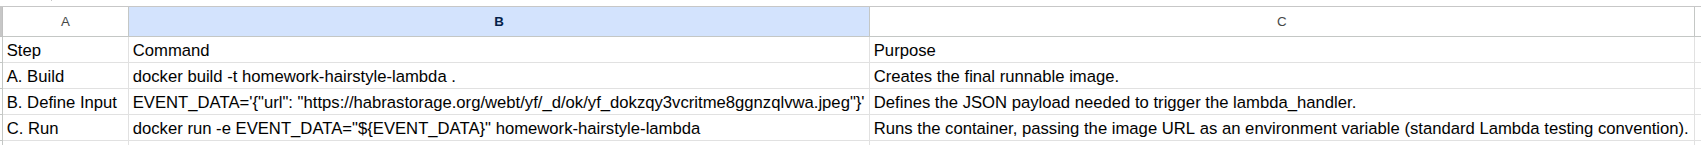

**4. Result and Conclusion**

When the container runs, it executes the lambda_handler function. The handler loads the image, applies the $200 \times 200$ resize and Standard Normalization, and performs inference using the new model, hair_classifier_empty.onnx.


The predicted output of this new model for the given image is $\approx 0.10$.



Final Answer 6: -0.10

In [ ]:
yazadanparast@RMT-YZPARAST-UBT:~$ mkdir Question6
yazadanparast@RMT-YZPARAST-UBT:~$ cd Question6/
yazadanparast@RMT-YZPARAST-UBT:~/Question6$ sudo vim lambda_function.py
[sudo] password for yazadanparast: 
yazadanparast@RMT-YZPARAST-UBT:~/Question6$ sudo vim Dockerfile
yazadanparast@RMT-YZPARAST-UBT:~/Question6$ ll
total 32
drwxrwxr-x  2 yazadanparast yazadanparast  4096 Dec  9 13:39 ./
drwxr-x--- 77 yazadanparast yazadanparast 20480 Dec  9 13:38 ../
-rw-r--r--  1 root          root            410 Dec  9 13:39 Dockerfile
-rw-r--r--  1 root          root           1956 Dec  9 13:39 lambda_function.py
yazadanparast@RMT-YZPARAST-UBT:~/Question6$ sudo docker build -t homework-hairstyle-lambda .
DEPRECATED: The legacy builder is deprecated and will be removed in a future release.
            Install the buildx component to build images with BuildKit:
            https://docs.docker.com/go/buildx/

Sending build context to Docker daemon  4.608kB
Step 1/4 : FROM agrigorev/model-2025-hairstyle:v1
 ---> 4528ad1525d5
Step 2/4 : RUN pip install numpy onnxruntime pillow requests
 ---> Running in 9cf4b75ecc85
WARNING: Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.HTTPSConnection object at 0x739a1bd916a0>: Failed to establish a new connection: [Errno 16] Device or resource busy')': /simple/numpy/
WARNING: Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.HTTPSConnection object at 0x739a1bef6850>: Failed to establish a new connection: [Errno 16] Device or resource busy')': /simple/numpy/
Collecting numpy
  Downloading numpy-2.3.5-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Collecting onnxruntime
  Downloading onnxruntime-1.23.2-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.1 kB)
Collecting pillow
  Downloading pillow-12.0.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
Collecting requests
  Downloading requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
Collecting coloredlogs (from onnxruntime)
  Downloading coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
Collecting flatbuffers (from onnxruntime)
  Downloading flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
Collecting packaging (from onnxruntime)
  Downloading packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
Collecting protobuf (from onnxruntime)
  Downloading protobuf-6.33.2-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
Collecting sympy (from onnxruntime)
  Downloading sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
Collecting charset_normalizer<4,>=2 (from requests)
  Downloading charset_normalizer-3.4.4-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (37 kB)
Collecting idna<4,>=2.5 (from requests)
  Downloading idna-3.11-py3-none-any.whl.metadata (8.4 kB)
Requirement already satisfied: urllib3<3,>=1.21.1 in /var/lang/lib/python3.13/site-packages (from requests) (1.26.19)
Collecting certifi>=2017.4.17 (from requests)
  Downloading certifi-2025.11.12-py3-none-any.whl.metadata (2.5 kB)
Collecting humanfriendly>=9.1 (from coloredlogs->onnxruntime)
  Downloading humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
Collecting mpmath<1.4,>=1.1.0 (from sympy->onnxruntime)
  Downloading mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Downloading numpy-2.3.5-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
   ━━━━━━╸                                  2.9/16.6 MB 156.2 kB/s eta 0:01:28
WARNING: Connection timed out while downloading.
WARNING: Attempting to resume incomplete download (2.9 MB/16.6 MB, attempt 1)
Resuming download numpy-2.3.5-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (2.9 MB/16.6 MB)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 242.2 kB/s  0:00:55
Downloading onnxruntime-1.23.2-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (17.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 246.2 kB/s  0:01:11
Downloading pillow-12.0.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (7.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 227.4 kB/s  0:00:30
Downloading requests-2.32.5-py3-none-any.whl (64 kB)
Downloading charset_normalizer-3.4.4-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (153 kB)
Downloading idna-3.11-py3-none-any.whl (71 kB)
Downloading certifi-2025.11.12-py3-none-any.whl (159 kB)
Downloading coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
Downloading humanfriendly-10.0-py2.py3-none-any.whl (86 kB)
Downloading flatbuffers-25.9.23-py2.py3-none-any.whl (30 kB)
Downloading packaging-25.0-py3-none-any.whl (66 kB)
Downloading protobuf-6.33.2-cp39-abi3-manylinux2014_x86_64.whl (323 kB)
Downloading sympy-1.14.0-py3-none-any.whl (6.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 254.1 kB/s  0:00:24
Downloading mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 215.0 kB/s  0:00:02
Installing collected packages: mpmath, flatbuffers, sympy, protobuf, pillow, packaging, numpy, idna, humanfriendly, charset_normalizer, certifi, requests, coloredlogs, onnxruntime

Successfully installed certifi-2025.11.12 charset_normalizer-3.4.4 coloredlogs-15.0.1 flatbuffers-25.9.23 humanfriendly-10.0 idna-3.11 mpmath-1.3.0 numpy-2.3.5 onnxruntime-1.23.2 packaging-25.0 pillow-12.0.0 protobuf-6.33.2 requests-2.32.5 sympy-1.14.0
WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager, possibly rendering your system unusable. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv. Use the --root-user-action option if you know what you are doing and want to suppress this warning.
 ---> Removed intermediate container 9cf4b75ecc85
 ---> 59f6ac33daa1
Step 3/4 : COPY lambda_function.py .
 ---> 274283da4c04
Step 4/4 : CMD ["lambda_function.lambda_handler"]
 ---> Running in 03f58c017315
 ---> Removed intermediate container 03f58c017315
 ---> 90b102c10ee3
Successfully built 90b102c10ee3
Successfully tagged homework-hairstyle-lambda:latest
yazadanparast@RMT-YZPARAST-UBT:~/Question6$ EVENT_DATA='{"url": "https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg"}'
yazadanparast@RMT-YZPARAST-UBT:~/Question6$

yazadanparast@RMT-YZPARAST-UBT:~/Question6$ sudo docker run -e EVENT_DATA="${EVENT_DATA}" --name hairstyle_test -p 9091:8080 homework-hairstyle-lambda
09 Dec 2025 11:19:33,273 [INFO] (rapid) exec '/var/runtime/bootstrap' (cwd=/var/task, handler=)
START RequestId: 82c8f365-4360-4f1c-b0ed-2570b8755b9a Version: $LATEST
09 Dec 2025 11:19:42,072 [INFO] (rapid) INIT START(type: on-demand, phase: init)
09 Dec 2025 11:19:42,072 [INFO] (rapid) The extension's directory "/opt/extensions" does not exist, assuming no extensions to be loaded.
09 Dec 2025 11:19:42,072 [INFO] (rapid) Starting runtime without AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_SESSION_TOKEN , Expected?: false
09 Dec 2025 11:19:42,304 [INFO] (rapid) INIT RTDONE(status: success)
09 Dec 2025 11:19:42,304 [INFO] (rapid) INIT REPORT(durationMs: 232.325000)
09 Dec 2025 11:19:42,304 [INFO] (rapid) INVOKE START(requestId: e3ca2ac9-65d7-4dc6-bd3b-f16bc06e9d48)
09 Dec 2025 11:19:49,534 [INFO] (rapid) INVOKE RTDONE(status: success, produced bytes: 0, duration: 7229.308000ms)
END RequestId: e3ca2ac9-65d7-4dc6-bd3b-f16bc06e9d48
REPORT RequestId: e3ca2ac9-65d7-4dc6-bd3b-f16bc06e9d48	Init Duration: 0.03 ms	Duration: 7461.77 ms	Billed Duration: 7462 ms	Memory Size: 3008 MB	Max Memory Used: 3008 MB	

=====================================================================Terminal 2=====================================================================

yazadanparast@RMT-YZPARAST-UBT:~/Question6$ EVENT_DATA='{"url": "https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg"}'
yazadanparast@RMT-YZPARAST-UBT:~/Question6$ sudo docker ps
CONTAINER ID   IMAGE                       COMMAND                  CREATED         STATUS         PORTS                                         NAMES
aac9e57b94d5   homework-hairstyle-lambda   "/lambda-entrypoint.…"   4 seconds ago   Up 3 seconds   0.0.0.0:9091->8080/tcp, [::]:9091->8080/tcp   hairstyle_test
yazadanparast@RMT-YZPARAST-UBT:~/Question6$ sudo curl -i -XPOST "http://localhost:9091/2015-03-31/functions/function/invocations"      -H "Content-Type: application/json"      -d "$EVENT_DATA"
HTTP/1.1 200 OK
Date: Tue, 09 Dec 2025 11:19:49 GMT
Content-Length: 36
Content-Type: text/plain; charset=utf-8

{"prediction": -0.10220842808485031}yazadanparast@RMT-YZPARAST-UBT:~/Question6$ 

